In [1]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy import kron
from scipy import linalg
from scipy.sparse import linalg
import matplotlib.pyplot as plt

In [2]:
def zz(L,delta):
# get the SzSz operators
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    s_z = 0.5*sz
    
    sz_list = [] # sz_list[i] = kron([id, id, ..., id, sz(ith), id, .... id])
    # So, sz_list[i+1] = kron([id, id, ..., id(ith), sz(i+1th), id, .... id])
    
    for i_site in range(L):
        z_ops = [id] * L
        z_ops[i_site] = s_z
        Z = z_ops[0]
        for j in range(1, L):
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sz_list.append(Z)
        
    # prepare a blank matrix for Hamiltonian:
    H_zz = sparse.csr_matrix((2**L, 2**L))
    
    for i in range(L):
        H_zz = H_zz + delta*sz_list[i]*sz_list[(i + 1) % L]
        
    return H_zz
    

Here is $S^z = 1/2 \sigma^z$ operaor. The Ising interaction in spin chain gives:
$$
H_{s_zs_z} = \Delta \mathbf{S}_{i} \cdot \mathbf{S}_{i+1}
$$

In [3]:
L=4     # length of chain, keep it smaller than ~16, :-)
delta = 1

IInteratcion = zz(L, delta)
         
howbig = IInteratcion.shape #check the dimension
# print(howbig)
# print(IInteratcion)

In [4]:
def xxyy(L,Jx,Jy):
    # get the SxSx operators
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sy = np.array([
        [0, -1j],
        [1j, 0]
    ])
    id = sparse.csr_matrix(np.eye(2))
    s_x = 0.5*sx
    s_y = 0.5*sy
    sx_list = []
    sy_list = []
    for i_site in range(L):
        x_ops = [id] * L
        y_ops = [id] * L
        x_ops[i_site] = s_x
        y_ops[i_site] = s_y
        X = x_ops[0]
        Y = y_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Y = sparse.kron(Y, y_ops[j], 'csr')
        sx_list.append(X)
        sy_list.append(Y)
        
    # prepare a blank matrix for Hamiltonian:
    H_xx = sparse.csr_matrix((2**L, 2**L))
    H_yy = sparse.csr_matrix((2**L, 2**L))
    
    for i in range(L):
        H_xx = H_xx + Jx*sx_list[i]*sx_list[(i + 1) % L]
        H_yy = H_yy + Jy*sy_list[i]*sy_list[(i + 1) % L]
    
    H_xxyy = H_xx + H_yy   
    return H_xxyy

Here use the spin operator:
$$
H_{s_xs_x s_ys_y} = J_xS^x_iS^x_j + J_yS^y_iS^y_j
$$


In [5]:
L=4     # length of chain, keep it smaller than ~16, :-)
Jx = 1
Jy = 1

Exchange = xxyy(L, Jx, Jy)
         
howbig = Exchange.shape #check the dimension
print(howbig)
# print(Exchange)

(16, 16)


So now the Ising interaction term and exchange term are finished.

In [6]:
L=4     # length of chain, keep it smaller than ~16, :-)
delta = 1
Jx = 1
Jy = 1

IInteratcion = zz(L, delta)
Exchange = xxyy(L, Jx, Jy)

Hamiltonian = IInteratcion + Exchange

In [7]:
# diagonalize
eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
print(min(eigs)/L)

-0.4040063509461095


In [8]:
# or use this diagonalize:
E,V = sp.sparse.linalg.eigsh(Hamiltonian, k=1,
                                  which='SA', return_eigenvectors=True,
                                  maxiter=1000)
print(min(E)/L)

-0.4040063509461097


------

Now we add the external field.

In [9]:
def hz_field(L, hz):
# get single site operaors
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    s_z = 0.5*sz
    sz_list = [] # sz_list[i] = kron([id, id, ..., id, sx, id, .... id])
    
    for i_site in range(L):
        z_ops = [id] * L
        z_ops[i_site] = s_z
        Z = z_ops[0]
        for j in range(1, L):
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sz_list.append(Z)
        
    H_z = sparse.csr_matrix((2**L, 2**L))
    
    for i in range(L):
        H_z = H_z + hz*sz_list[i]
        
    z_f = - H_z # negetive Longitudinal field
    
    return z_f

$$
-h_z \sum_i S^z_i
$$

In [10]:
L=4     # length of chain, keep it smaller than ~16, :-)
delta = 1.0
Jx = 1
Jy = 1
hz = 0.1

IInteratcion = zz(L, delta)
Exchange = xxyy(L, Jx, Jy)
Longitudinal_F = hz_field(L, hz)

Hamiltonian = IInteratcion + Exchange + Longitudinal_F

# diagonalize
eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
print(min(eigs)/L)

-0.4040063509461096


The longitudinal field is very small $h_z<<1.0$ and we can see that there is no change in the ground state energy.

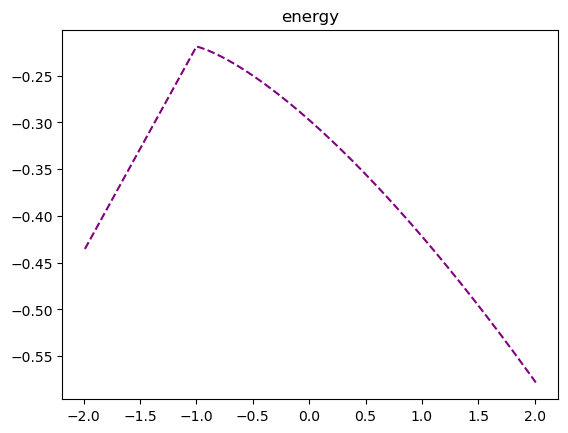

In [11]:
## changing coupling when closed hz

L=8     # length of chain, keep it smaller than ~16, :-)
delta = -2.0
Jx = 1
Jy = 1
hz = 0

D_array = np.array([])
E = np.array([])

for i in range(int(4/0.01)+1):
    delta += 0.01

    IInteratcion = zz(L, delta)
    Exchange = xxyy(L, Jx, Jy)
    # Longitudinal_F = hz_field(L, hz)

    Hamiltonian = IInteratcion + Exchange #+ Longitudinal_F
        
    # diagonalize
    eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
    
    D_array = np.append(D_array,delta) #xishu = Delta
    E = np.append(E, min(eigs)/L)
    
    
plt.plot(D_array,E,'--',color='purple')
plt.title('energy')
plt.show()

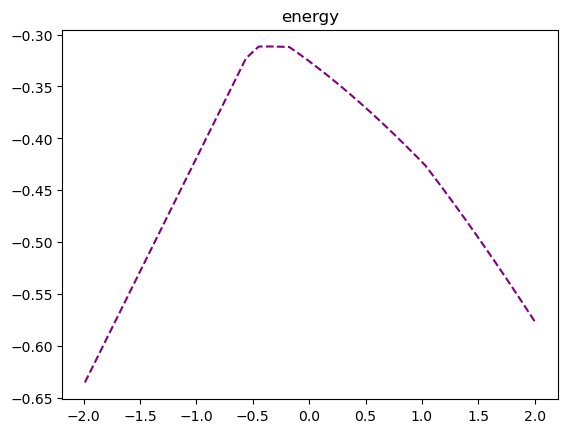

In [12]:
## changing coupling and fixed hz

L=8     # length of chain, keep it smaller than ~16, :-)
delta = -2.0
Jx = 1
Jy = 1
hz = 0.4

D_array = np.array([])
E = np.array([])

for i in range(int(4/0.01)+1):
    delta += 0.01

    IInteratcion = zz(L, delta)
    Exchange = xxyy(L, Jx, Jy)
    Longitudinal_F = hz_field(L, hz)

    Hamiltonian = IInteratcion + Exchange + Longitudinal_F
        
    # diagonalize
    eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
    
    D_array = np.append(D_array,delta) #xishu = Delta
    E = np.append(E, min(eigs)/L)
    
    
plt.plot(D_array,E,'--',color='purple')
plt.title('energy')
plt.show()

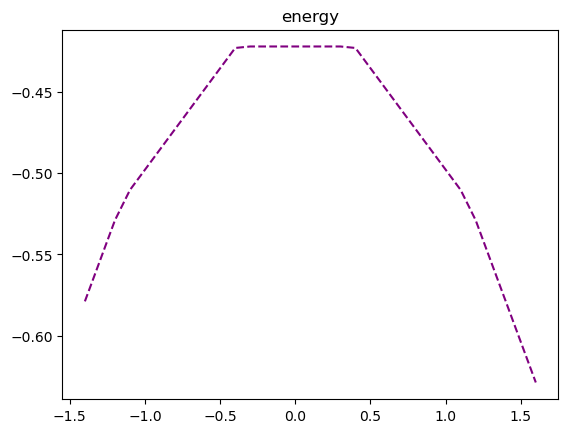

In [13]:
## changing hz and fixed coupling

L=8     # length of chain, keep it smaller than ~16, :-)
delta = 1.0
Jx = 1
Jy = 1
hz = -1.5

hz_array = np.array([])
E = np.array([])

for i in range(30+1):
    hz += 0.1

    IInteratcion = zz(L, delta)
    Exchange = xxyy(L, Jx, Jy)
    Longitudinal_F = hz_field(L, hz)

    Hamiltonian = IInteratcion + Exchange + Longitudinal_F
        
    # diagonalize
    eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
    
    hz_array = np.append(hz_array,hz) #xishu = Delta
    E = np.append(E, min(eigs)/L)
    
       
plt.plot(hz_array,E,'--',color='purple')
plt.title('energy')
plt.show()   

Text(0.5, 1.0, 'Energy Level')

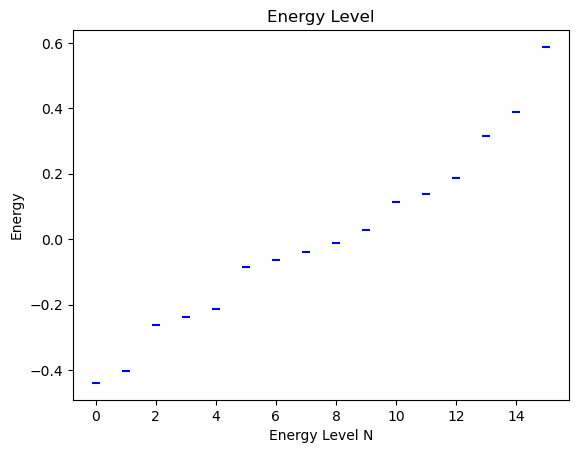

In [14]:
# check energy level

L=4     # length of chain, keep it smaller than ~16, :-)
delta = 1.0
Jx = 1
Jy = 1
hz = 0.8

IInteratcion = zz(L, delta)
Exchange = xxyy(L, Jx, Jy)
Longitudinal_F = hz_field(L, hz)

Hamiltonian = IInteratcion + Exchange + Longitudinal_F

eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
        
energy_level=np.sort(eigs/L)
plt.scatter(np.arange(0,len(energy_level)),energy_level,marker='_',color='blue')
plt.xlabel('Energy Level N')
plt.ylabel('Energy')
plt.title('Energy Level')

In [15]:
def hx_field(L, hx):
# get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    id = sparse.csr_matrix(np.eye(2))
    s_x = sx*0.5
    
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    for i_site in range(L):
        x_ops = [id] * L
        x_ops[i_site] = s_x
        X = x_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
        sx_list.append(X)
    H_x = sparse.csr_matrix((2**L, 2**L))
    
    for i in range(L):
        H_x = H_x + hx*sx_list[i] 
    x_f = - H_x
    
    return x_f

$$
-h_x \sum_i S^x_i
$$

Text(0.5, 1.0, 'Energy Level')

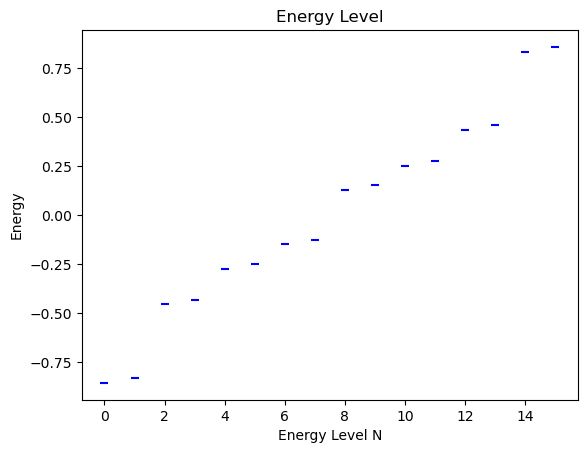

In [16]:
# check energy level

L=4     # length of chain, keep it smaller than ~16, :-)
delta = -1.0
Jx = 0 #check compare with Ising
Jy = 0 #check compare with Ising
hx = 0.5

IInteratcion = zz(L, delta)
Exchange = xxyy(L, Jx, Jy)
Transverse_F = hx_field(L, hx)

Hamiltonian = 4*IInteratcion + Exchange + 2*Transverse_F

eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
        
energy_level=np.sort(eigs/L)
plt.scatter(np.arange(0,len(energy_level)),energy_level,marker='_',color='blue')
plt.xlabel('Energy Level N')
plt.ylabel('Energy')
plt.title('Energy Level')

XXZ+hx closed exchange term and $\times 4$ interaction term, $\times 2$ hx term when use spin operator.  It's same as TFIM using same parameters: $\Delta = -J = -1, h_x = 0.5, H_{TFIS} = \sum -J ... -h_x ..$

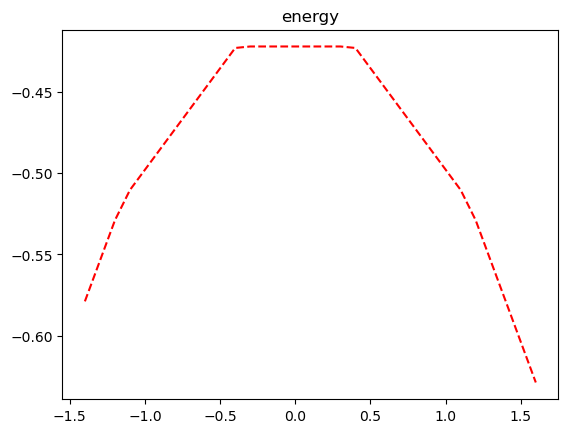

In [17]:
## changing hz and fixed coupling

L=8     # length of chain, keep it smaller than ~16, :-)
delta = 1.0
Jx = 1
Jy = 1
hx = -1.5

hx_array = np.array([])
E_x = np.array([])

for i in range(30+1):
    hx += 0.1

    IInteratcion = zz(L, delta)
    Exchange = xxyy(L, Jx, Jy)
    Transverse_F = hx_field(L, hx)

    Hamiltonian_x = IInteratcion + Exchange + Transverse_F
        
    # diagonalize
    eigs = sp.linalg.eigh(Hamiltonian_x.todense(), eigvals_only=True)
    
    hx_array = np.append(hx_array,hx) #xishu = Delta
    E_x = np.append(E_x, min(eigs)/L)
    
       
plt.plot(hx_array,E_x,'--',color='red')
plt.title('energy')
plt.show()   

add Transverse_Field and Longitudinal_F both

In [18]:
L=8     # length of chain, keep it smaller than ~16, :-)
delta = 1.0
Jx = 1
Jy = 1
hz = 0.4 #in SSE, hz = 2hb, when hb = 2.0, hx = 2.0
hx = 2.0 #in SSE, hx = 2gamma, when gamma = 2.0, hx = 2.0

IInteratcion = zz(L, delta)
Exchange = xxyy(L, Jx, Jy)
Longitudinal_F = hz_field(L, hz)
Transverse_F = hx_field(L, hx)

Hamiltonian = IInteratcion + Exchange + Longitudinal_F + Transverse_F

# diagonalize
eigs = sp.linalg.eigh(Hamiltonian.todense(), eigvals_only=True)
print(min(eigs)/L)

-0.8010539027185564


和用MATLAB写的版本是一样的结果，现在也不知道是不是这样的ED就是对的，或者说两个都错。
两个都错，问题只可能是缝场的思想可能有问题。